In [2]:
# --- Importing Libraries ---
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import yellowbrick
import pickle
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC, ConfusionMatrix
from yellowbrick.style import set_palette
from yellowbrick.model_selection import LearningCurve, FeatureImportances
from yellowbrick.contrib.wrapper import wrap
from matplotlib.collections import PathCollection
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import MinMaxScaler


# --- Libraries Settings ---
pd.set_option("display.precision", 4)
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi']=100
set_palette('dark')


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# --- Importing Dataset ---
df = pd.read_csv('cardio_train.csv',sep=';')

# --- Reading Dataset ---
df.head(10).style.background_gradient(cmap='Reds').set_properties(**{'font-family': 'Segoe UI'}).hide_index()

id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.000000,110,80,1,1,0,0,1,0
1,20228,1,156,85.000000,140,90,3,1,0,0,1,1
2,18857,1,165,64.000000,130,70,3,1,0,0,0,1
3,17623,2,169,82.000000,150,100,1,1,0,0,1,1
4,17474,1,156,56.000000,100,60,1,1,0,0,0,0
8,21914,1,151,67.000000,120,80,2,2,0,0,0,0
9,22113,1,157,93.000000,130,80,3,1,0,0,1,0
12,22584,2,178,95.000000,130,90,3,3,0,0,1,1
13,17668,1,158,71.000000,110,70,1,1,0,0,1,0
14,19834,1,164,68.000000,110,60,1,1,0,0,0,0


In [9]:
#cleaning up the dataset by redfining datatset in terms of converting cardio intro a string, calculating age, getting height into proper units and calucalting bmi
df[['cardio']] = df[['cardio']].astype(str)
df['year']= (df['age']/365).round(0)
df['height(m)']= (df['height']/100).round(3)
df['BMI']= (df['weight']/((df['height(m)'])*df['height(m)']))
df = df.drop(columns=['height','age'])

In [18]:
df['year']=df['year'].astype('int64')
df['height(m)']=df['height(m)'].astype('int64')
df['BMI']=df['BMI'].astype('int64')
df['weight']=df['weight'].astype('int64')

In [19]:
# --- Print Dataset Info ---
print('\033[1m'+'.: Dataset Info :.'+'\033[0m')
print('*' * 30)
print('Total Rows:'+'\033[1m', df.shape[0])
print('\033[0m'+'Total Columns:'+'\033[1m', df.shape[1])
print('\033[0m'+'*' * 30)
print('\n')

# --- Print Dataset Detail ---
print('\033[1m'+'.: Dataset Details :.'+'\033[0m')
print('*' * 30)
df.info(memory_usage = False)

.: Dataset Info :.
******************************
Total Rows: 70000
Total Columns: 14
******************************


.: Dataset Details :.
******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           70000 non-null  int64 
 1   gender       70000 non-null  int64 
 2   weight       70000 non-null  int64 
 3   ap_hi        70000 non-null  int64 
 4   ap_lo        70000 non-null  int64 
 5   cholesterol  70000 non-null  int64 
 6   gluc         70000 non-null  int64 
 7   smoke        70000 non-null  int64 
 8   alco         70000 non-null  int64 
 9   active       70000 non-null  int64 
 10  cardio       70000 non-null  object
 11  year         70000 non-null  int64 
 12  height(m)    70000 non-null  int64 
 13  BMI          70000 non-null  int64 
dtypes: int64(13), object(1)

In [20]:
# --- finding out the null values of the dataset --- 
df.isnull().sum()

id             0
gender         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
year           0
height(m)      0
BMI            0
dtype: int64

(None, None)

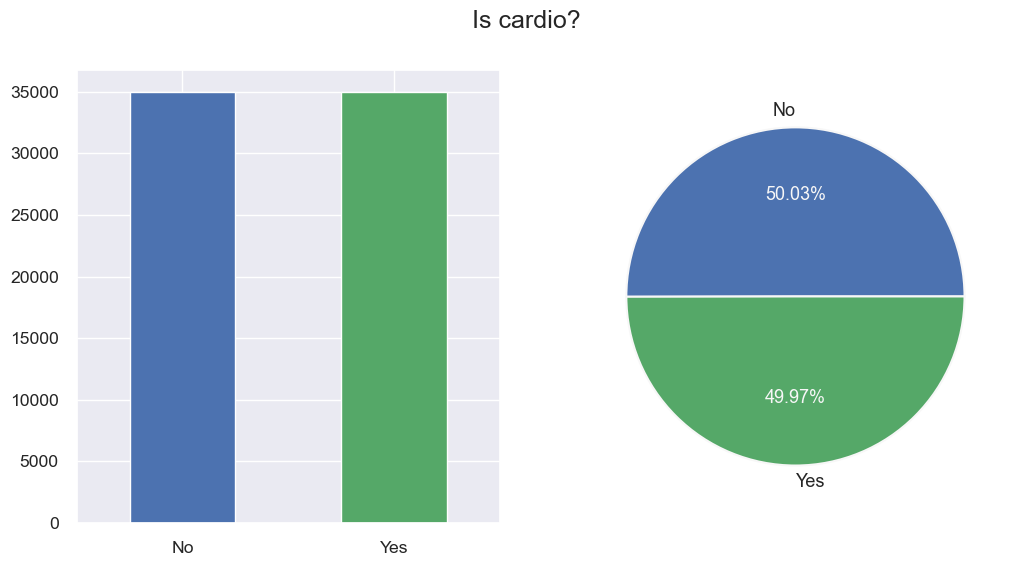

In [21]:
f, ax = plt.subplots(1, 2, figsize = (12, 6))
f.suptitle("Is cardio?", fontsize = 18.)
_ = df.cardio.value_counts().plot.bar(ax = ax[0], rot = 0, 
                                            color = (sns.color_palette()[0], sns.color_palette()[2])).set(xticklabels = ["No", "Yes"])
_ = df.cardio.value_counts().plot.pie(labels = ("No", "Yes"), autopct = "%.2f%%", 
                                            label = "", fontsize = 13., ax = ax[1],\
colors = (sns.color_palette()[0], sns.color_palette()[2]), wedgeprops = {"linewidth": 1.5, "edgecolor": "#F7F7F7"}), 
ax[1].texts[1].set_color("#F7F7F7"), ax[1].texts[3].set_color("#F7F7F7")

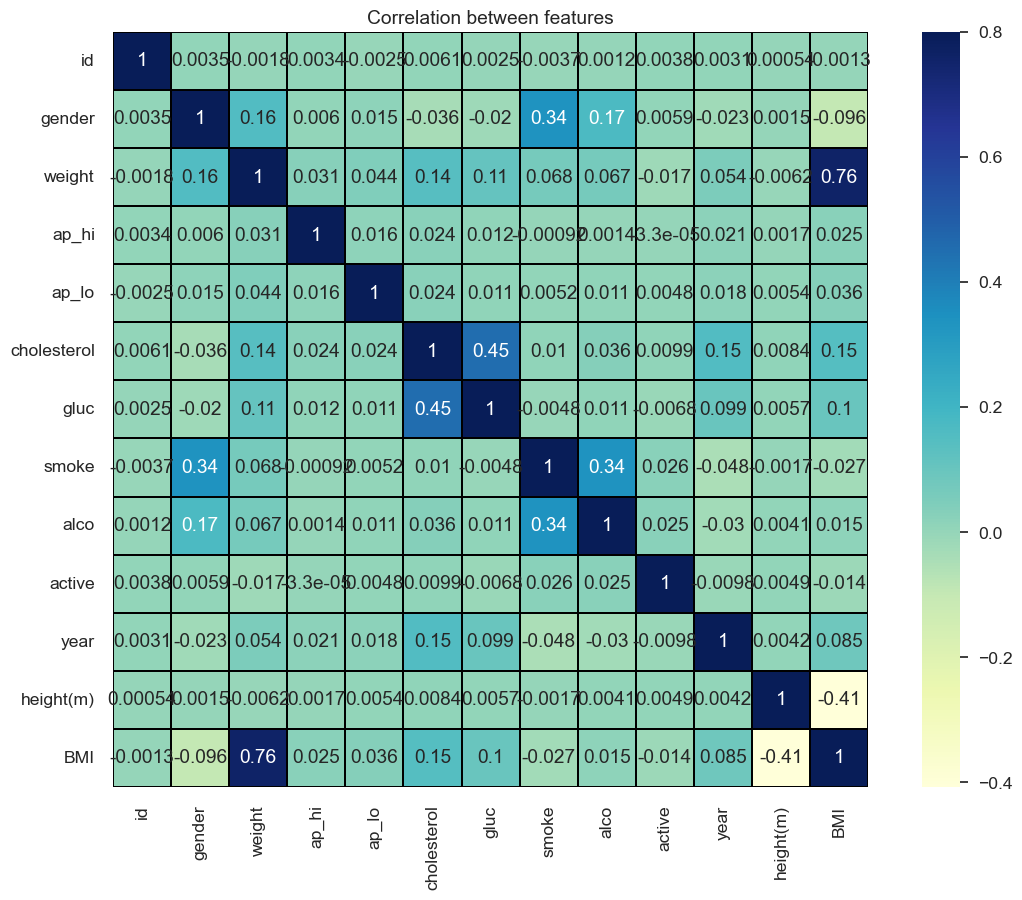

In [22]:
corr=df.corr()

sns.set(font_scale=1.15)
plt.figure(figsize=(14, 10))

sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="black")
plt.title('Correlation between features');

In [23]:
X = df.iloc[:,1:-1]
y = df.iloc[:, -1]
X

,gender,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,year,height(m)
0,2,62,110,80,1,1,0,0,1,0,50,1
1,1,85,140,90,3,1,0,0,1,1,55,1
2,1,64,130,70,3,1,0,0,0,1,52,1
3,2,82,150,100,1,1,0,0,1,1,48,1
4,1,56,100,60,1,1,0,0,0,0,48,1
...,...,...,...,...,...,...,...,...,...,...,...,...
69995,2,76,120,80,1,1,1,0,1,0,53,1
69996,1,126,140,90,2,2,0,0,1,1,62,1
69997,2,105,180,90,3,1,0,1,0,1,52,1
69998,1,72,135,80,1,2,0,0,0,1,61,1


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [25]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [26]:
# --- Applying Logistic Regression ---
classifier_lr = LogisticRegression(random_state = 42)
classifier_lr.fit(X_train, y_train)
# --- Predicting the test values ---
y_pred_lr = classifier_lr.predict(X_test)
# # --- Scoring ---
# acc_lr = accuracy_score(y_test, y_pred_lr)
# f1_lr = f1_score(y_test, y_pred_lr)

In [27]:
# --- LR Accuracy ---
acc_lr = accuracy_score(y_pred_lr, y_test)
print('.:. Logistic Regression Accuracy:'+'\033[1m {:.2f}%'.format(acc_lr*100)+' .:.')

# --- LR Classification Report ---
print('\n\033[1m'+'.: Classification Report'+'\033[0m')
print('*' * 25)
print(classification_report(y_test, y_pred_lr))

.:. Logistic Regression Accuracy: 20.79% .:.

.: Classification Report
*************************
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00        29
          17       0.17      0.06      0.09        52
          18       0.50      0.02      0.03       113
          19       0.17      0.14      0.15       183
          20       0.24      0.15      0.18       367
          21       0.27      0.08      0.12       566
          22       0.24      0.21      0.23       898
          23       0.29      0.47      0.36      1567
          24       0.23      0.35      0.28      1520
          25       0.22      0.21      0.22      1273
          26       0.19      0.09      0.12      1126
          27       0.18      0.29     


.: Performance Evaluation
**************************


ModelError: could not decode [  7   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25
  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  64  65  66  67  68  69  70  72  74  85  86 106 108 126 133 134 138
 140 142 146 147 148 152 165 170 178 191 237 267 278 298] y values to ['False' 'True'] labels

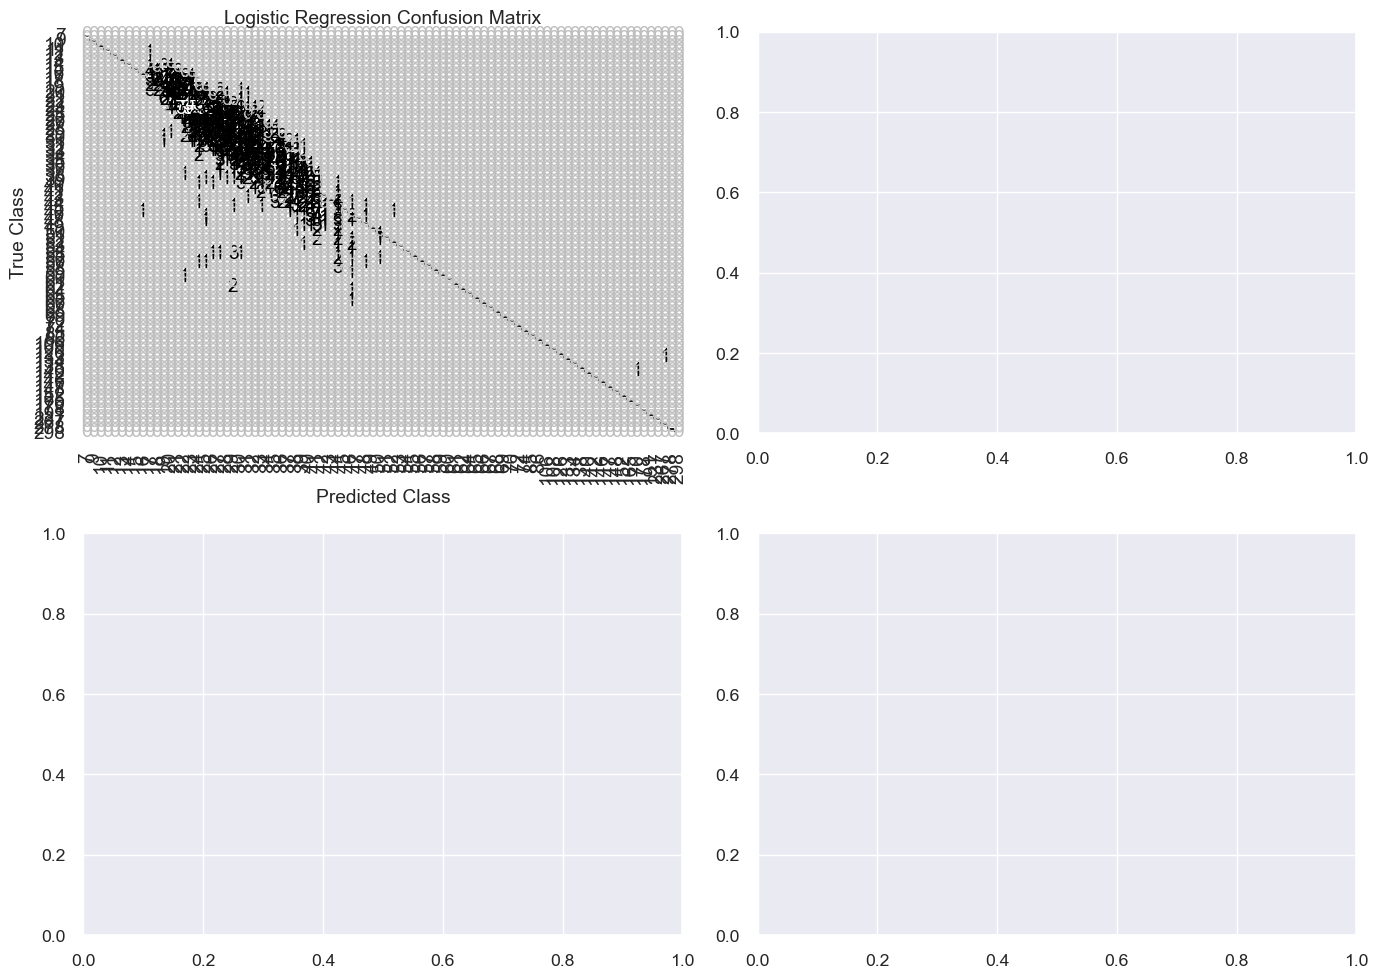

In [28]:
# --- Performance Evaluation ---
print('\n\033[1m'+'.: Performance Evaluation'+'\033[0m')
print('*' * 26)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# --- LR Confusion Matrix ---
logmatrix = ConfusionMatrix(classifier_lr, ax=ax1, cmap='PuRd',
                            title='Logistic Regression Confusion Matrix')
logmatrix.fit(X_train, y_train)
logmatrix.score(X_test, y_test)
logmatrix.finalize()

# --- LR ROC AUC ---
logrocauc = ROCAUC(classifier_lr, classes=['False', 'True'], ax=ax2,
                   title='Logistic Regression ROC AUC Plot')
logrocauc.fit(X_train, y_train)
logrocauc.score(X_test, y_test)
logrocauc.finalize()

# --- LR Learning Curve ---
loglc = LearningCurve(classifier_lr, ax=ax3, title='Logistic Regression Learning Curve')
loglc.fit(X_train, y_train)
loglc.finalize()

# --- LR Precision Recall Curve ---
logcurve = PrecisionRecallCurve(classifier_lr, ax=ax4, ap_score=True, iso_f1_curves=True,
                                title='Logistic Regression Precision-Recall Curve')
logcurve.fit(X_train, y_train)
logcurve.score(X_test, y_test)
logcurve.finalize()

plt.tight_layout();

In [29]:
"""
Power parameter for the Minkowski metric. 
When p = 1, this is equivalent to using manhattan_distance (l1), 
and euclidean_distance (l2) for p = 2. 
"""
# --- Applying KNN ---
KNNClassifier = KNeighborsClassifier(n_neighbors=3)
KNNClassifier.fit(X_train, y_train)

y_pred_KNN = KNNClassifier.predict(X_test)

In [30]:
# --- KNN Accuracy ---
KNNAcc = accuracy_score(y_pred_KNN, y_test)
print('.:. K-Nearest Neighbour Accuracy:'+'\033[1m {:.2f}%'.format(KNNAcc*100)+' .:.')

# --- KNN Classification Report ---
print('\n\033[1m'+'.: Classification Report'+'\033[0m')
print('*' * 25)
print(classification_report(y_test, y_pred_KNN))

.:. K-Nearest Neighbour Accuracy: 15.32% .:.

.: Classification Report
*************************
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         0
          15       0.10      0.20      0.13         5
          16       0.12      0.07      0.09        29
          17       0.12      0.17      0.14        52
          18       0.13      0.19      0.16       113
          19       0.11      0.19      0.14       183
          20       0.13      0.18      0.15       367
          21       0.12      0.17      0.14       566
          22       0.14      0.20      0.16       898
          23       0.24      0.30      0.27      1567
          24       0.20      0.23      0.21      1520
          25       0.17      0.18     


.: Performance Evaluation
**************************


ModelError: could not decode [  7   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25
  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  64  65  66  67  68  69  70  72  74  85  86 106 108 126 133 134 138
 140 142 146 147 148 152 165 170 178 191 237 267 278 298] y values to ['False' 'True'] labels

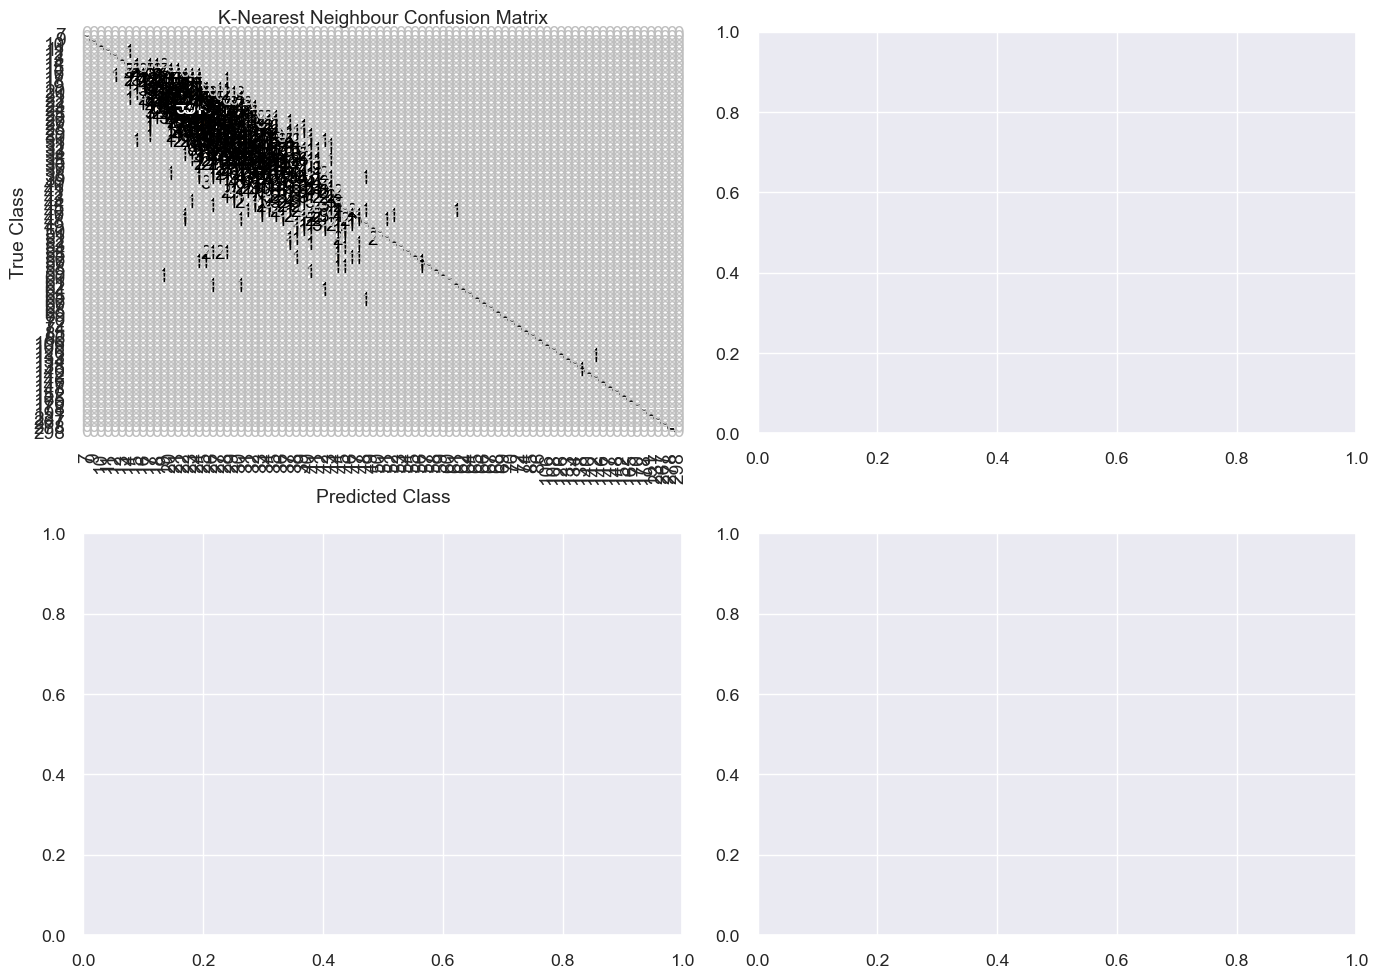

In [31]:
# --- Performance Evaluation ---
print('\n\033[1m'+'.: Performance Evaluation'+'\033[0m')
print('*' * 26)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# --- KNN Confusion Matrix ---
knnmatrix = ConfusionMatrix(KNNClassifier, ax=ax1, cmap='Oranges',
                            title='K-Nearest Neighbour Confusion Matrix')
knnmatrix.fit(X_train, y_train)
knnmatrix.score(X_test, y_test)
knnmatrix.finalize()

# --- KNN ROC AUC ---
knnrocauc = ROCAUC(KNNClassifier, classes=['False', 'True'], ax=ax2,
                   title='K-Nearest Neighbour ROC AUC Plot')
knnrocauc.fit(X_train, y_train)
knnrocauc.score(X_test, y_test)
knnrocauc.finalize()

# --- KNN Learning Curve ---
knnlc = LearningCurve(KNNClassifier, ax=ax3, title='K-Nearest Neighbour Learning Curve')
knnlc.fit(X_train, y_train)
knnlc.finalize()

# --- KNN Precision Recall Curve ---
knncurve = PrecisionRecallCurve(KNNClassifier, ax=ax4, ap_score=True, iso_f1_curves=True,
                                 title='K-Nearest Neighbour Precision-Recall Curve')
knncurve.fit(X_train, y_train)
knncurve.score(X_test, y_test)
knncurve.finalize()

plt.tight_layout();

In [ ]:
# --- Applying SVM ---
SVMclassifier = SVC(kernel='linear', max_iter=1000, C=10, probability=True)
SVMclassifier.fit(X_train, y_train)

y_pred_SVM = SVMclassifier.predict(X_test)

In [ ]:
# --- SVM Accuracy ---
SVMAcc = accuracy_score(y_pred_SVM, y_test)
print('.:. Support Vector Machine Accuracy:'+'\033[1m {:.2f}%'.format(SVMAcc*100)+' .:.')

# --- SVM Classification Report ---
print('\n\033[1m'+'.: Classification Report'+'\033[0m')
print('*' * 25)
print(classification_report(y_test, y_pred_SVM))

In [ ]:
# --- Performance Evaluation ---
print('\n\033[1m'+'.: Performance Evaluation'+'\033[0m')
print('*' * 26)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# --- SVM Confusion Matrix ---
svmmatrix = ConfusionMatrix(SVMclassifier, ax=ax1, cmap='YlGn',
                            title='Support Vector Machine Confusion Matrix')
svmmatrix.fit(X_train, y_train)
svmmatrix.score(X_test, y_test)
svmmatrix.finalize()

# --- SVM ROC AUC ---
svmrocauc = ROCAUC(SVMclassifier, classes=['False', 'True'], ax=ax2,
                   title='Support Vector Machine ROC AUC Plot')
svmrocauc.fit(X_train, y_train)
svmrocauc.score(X_test, y_test)
svmrocauc.finalize()

# --- SVM Learning Curve ---
svmlc = LearningCurve(SVMclassifier, ax=ax3, title='Support Vector Machine Learning Curve')
svmlc.fit(X_train, y_train)
svmlc.finalize()

# --- SVM Precision Recall Curve ---
svmcurve = PrecisionRecallCurve(SVMclassifier, ax=ax4, ap_score=True, iso_f1_curves=True,
                                title='Support Vector Machine Precision-Recall Curve')
svmcurve.fit(X_train, y_train)
svmcurve.score(X_test, y_test)
svmcurve.finalize()

plt.tight_layout();

In [ ]:
# --- Applying Gaussian NB ---
GNBclassifier = GaussianNB(var_smoothing=0.1)
GNBclassifier.fit(X_train, y_train)

y_pred_GNB = GNBclassifier.predict(X_test)

In [ ]:
# --- GNB Accuracy ---
GNBAcc = accuracy_score(y_pred_GNB, y_test)
print('.:. Gaussian Naive Bayes Accuracy:'+'\033[1m {:.2f}%'.format(GNBAcc*100)+' .:.')

# --- GNB Classification Report ---
print('\n\033[1m'+'.: Classification Report'+'\033[0m')
print('*' * 25)
print(classification_report(y_test, y_pred_GNB))

In [ ]:
# --- Performance Evaluation ---
print('\n\033[1m'+'.: Performance Evaluation'+'\033[0m')
print('*' * 26)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# --- GNB Confusion Matrix ---
gnbmatrix = ConfusionMatrix(GNBclassifier, ax=ax1, cmap='GnBu',
                            title='Gaussian Naive Bayes Confusion Matrix')
gnbmatrix.fit(X_train, y_train)
gnbmatrix.score(X_test, y_test)
gnbmatrix.finalize()

# --- GNB ROC AUC ---
gnbrocauc = ROCAUC(GNBclassifier, classes=['False', 'True'], ax=ax2,
                   title='Gaussian Naive Bayes ROC AUC Plot')
gnbrocauc.fit(X_train, y_train)
gnbrocauc.score(X_test, y_test)
gnbrocauc.finalize()

# --- GNB Learning Curve ---
gnblc = LearningCurve(GNBclassifier, ax=ax3, title='Gaussian Naive Bayes Learning Curve')
gnblc.fit(X_train, y_train)
gnblc.finalize()

# --- GNB Precision Recall Curve ---
gnbcurve = PrecisionRecallCurve(GNBclassifier, ax=ax4, ap_score=True, iso_f1_curves=True,
                                title='Gaussian Naive Bayes Precision-Recall Curve')
gnbcurve.fit(X_train, y_train)
gnbcurve.score(X_test, y_test)
gnbcurve.finalize()

plt.tight_layout();

In [ ]:
# --- Applying Decision Tree ---
DTCclassifier = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, criterion='entropy', min_samples_split=5,
                                       splitter='random', random_state=1)

DTCclassifier.fit(X_train, y_train)
y_pred_DTC = DTCclassifier.predict(X_test)

In [ ]:
# --- Decision Tree Accuracy ---
DTCAcc = accuracy_score(y_pred_DTC, y_test)
print('.:. Decision Tree Accuracy:'+'\033[1m {:.2f}%'.format(DTCAcc*100)+' .:.')

# --- Decision Tree Classification Report ---
print('\n\033[1m'+'.: Classification Report'+'\033[0m')
print('*' * 25)
print(classification_report(y_test, y_pred_DTC))

In [ ]:
# --- Performance Evaluation ---
print('\n\033[1m'+'.: Performance Evaluation'+'\033[0m')
print('*' * 26)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# --- Decision Tree Confusion Matrix ---
dtcmatrix = ConfusionMatrix(DTCclassifier, ax=ax1, cmap='Greys',
                            title='Decision Tree Confusion Matrix')
dtcmatrix.fit(X_train, y_train)
dtcmatrix.score(X_test, y_test)
dtcmatrix.finalize()

# --- Decision Tree ROC AUC ---
dtcrocauc = ROCAUC(DTCclassifier, classes=['False', 'True'], ax=ax2,
                   title='Decision Tree ROC AUC Plot')
dtcrocauc.fit(X_train, y_train)
dtcrocauc.score(X_test, y_test)
dtcrocauc.finalize()

# --- Decision Tree Learning Curve ---
dtclc = LearningCurve(DTCclassifier, ax=ax3, title='Decision Tree Learning Curve')
dtclc.fit(X_train, y_train)
dtclc.finalize()

# --- Decision Tree Precision Recall Curve ---
dtccurve = PrecisionRecallCurve(DTCclassifier, ax=ax4, ap_score=True, iso_f1_curves=True, 
                                title='Decision Tree Precision-Recall Curve')
dtccurve.fit(X_train, y_train)
dtccurve.score(X_test, y_test)
dtccurve.finalize()

plt.tight_layout();

In [ ]:
# --- Applying Random Forest ---
RFclassifier = RandomForestClassifier(n_estimators=1000, random_state=1, max_leaf_nodes=20, min_samples_split=15)

RFclassifier.fit(X_train, y_train)
y_pred_RF = RFclassifier.predict(X_test)

In [ ]:
# --- Random Forest Accuracy ---
RFAcc = accuracy_score(y_pred_RF, y_test)
print('.:. Random Forest Accuracy:'+'\033[1m {:.2f}%'.format(RFAcc*100)+' .:.')

# --- Random FOrest Classification Report ---
print('\n\033[1m'+'.: Classification Report'+'\033[0m')
print('*' * 25)
print(classification_report(y_test, y_pred_RF))


.: Performance Evaluation
**************************


NameError: name 'RFclassifier' is not defined

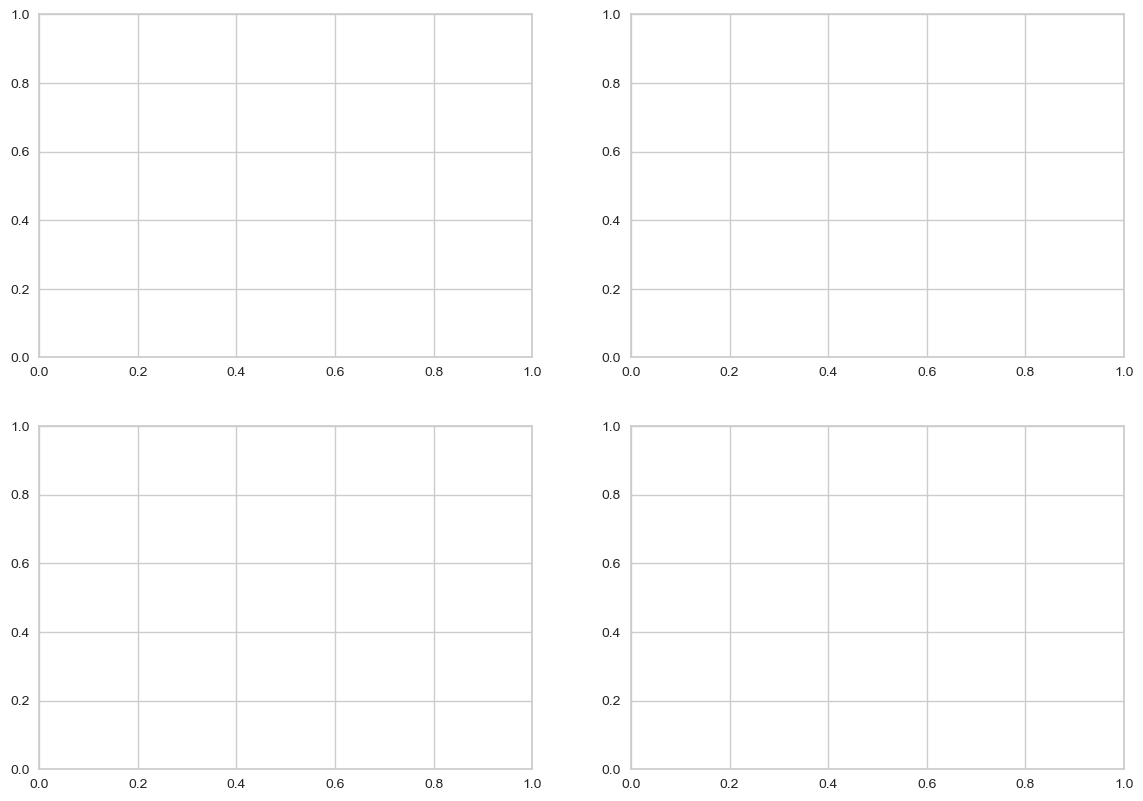

In [7]:
# --- Performance Evaluation ---
print('\n\033[1m'+'.: Performance Evaluation'+'\033[0m')
print('*' * 26)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# --- Random Forest Confusion Matrix ---
rfcmatrix = ConfusionMatrix(RFclassifier, ax=ax1, cmap='Purples',
                            title='Random Forest Confusion Matrix')
rfcmatrix.fit(X_train, y_train)
rfcmatrix.score(X_test, y_test)
rfcmatrix.finalize()

# --- Random Forest ROC AUC ---
rccrocauc = ROCAUC(RFclassifier, classes=['False', 'True'], ax=ax2,
                   title='Random Forest ROC AUC Plot')
rccrocauc.fit(X_train, y_train)
rccrocauc.score(X_test, y_test)
rccrocauc.finalize()

# --- Random Forest Learning Curve ---
rcclc = LearningCurve(RFclassifier, ax=ax3, title='Random Forest Learning Curve')
rcclc.fit(X_train, y_train)
rcclc.finalize()

# --- Random Forest Precision Recall Curve ---
rcccurve = PrecisionRecallCurve(RFclassifier, ax=ax4, ap_score=True, iso_f1_curves=True, 
                                title='Random Forest Precision-Recall Curve')
rcccurve.fit(X_train, y_train)
rcccurve.score(X_test, y_test)
rcccurve.finalize()

plt.tight_layout();

In [ ]:
# --- Applying ET ---
ETclassifier = ExtraTreesClassifier(n_estimators=15, random_state=47)

ETclassifier.fit(X_train, y_train)
y_pred_ET = ETclassifier.predict(X_test)

In [ ]:
# --- ET Accuracy ---
ETAcc = accuracy_score(y_pred_ET, y_test)
print('.:. Extra Tree Classifier Accuracy:'+'\033[1m {:.2f}%'.format(ETAcc*100)+' .:.')

# --- ET Classification Report ---
print('\n\033[1m'+'.: Classification Report'+'\033[0m')
print('*' * 25)
print(classification_report(y_test, y_pred_ET))

In [ ]:
# --- Performance Evaluation ---
print('\n\033[1m'+'.: Performance Evaluation'+'\033[0m')
print('*' * 26)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# --- ET Confusion Matrix ---
etcmatrix = ConfusionMatrix(ETclassifier, ax=ax1, cmap='PuRd',
                            title='Extra Tree Classifier Confusion Matrix')
etcmatrix.fit(X_train, y_train)
etcmatrix.score(X_test, y_test)
etcmatrix.finalize()

# --- ET ROC AUC ---
etrocauc = ROCAUC(ETclassifier, classes=['False', 'True'], ax=ax2,
                  title='Extra Tree Classifier ROC AUC Plot')
etrocauc.fit(X_train, y_train)
etrocauc.score(X_test, y_test)
etrocauc.finalize()

# --- ET Learning Curve ---
etlc = LearningCurve(ETclassifier, ax=ax3, title='Extra Tree Classifier Learning Curve')
etlc.fit(X_train, y_train)
etlc.finalize()

# --- ET Precision Recall Curve ---
etpc = PrecisionRecallCurve(ETclassifier, ax=ax4, ap_score=True, iso_f1_curves=True, 
                            title='Extra Tree Classifier Precision-Recall Curve')
etpc.fit(X_train, y_train)
etpc.score(X_test, y_test)
etpc.finalize()

plt.tight_layout();

In [ ]:
# --- Applying Gradient Boosting ---
GBclassifier = GradientBoostingClassifier(random_state=1, n_estimators=100, max_leaf_nodes=3, loss='exponential', 
                                          min_samples_leaf=20)

GBclassifier.fit(X_train, y_train)
y_pred_GB = GBclassifier.predict(X_test)

In [ ]:
# --- Gradient Boosting Accuracy ---
GBAcc = accuracy_score(y_pred_GB, y_test)
print('.:. Gradient Boosting Accuracy:'+'\033[1m {:.2f}%'.format(GBAcc*100)+' .:.')

# --- Gradient Boosting Classification Report ---
print('\n\033[1m'+'.: Classification Report'+'\033[0m')
print('*' * 25)
print(classification_report(y_test, y_pred_GB))

In [ ]:
# --- Performance Evaluation ---
print('\n\033[1m'+'.: Performance Evaluation'+'\033[0m')
print('*' * 26)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# --- Gradient Boosting Confusion Matrix ---
gbcmatrix = ConfusionMatrix(GBclassifier, ax=ax1, cmap='OrRd',
                            title='Gradient Boosting Confusion Matrix')
gbcmatrix.fit(X_train, y_train)
gbcmatrix.score(X_test, y_test)
gbcmatrix.finalize()

# --- Gradient Boosting ROC AUC ---
gbcrocauc = ROCAUC(GBclassifier, classes=['False', 'True'], ax=ax2,
                   title='Gradient Boosting ROC AUC Plot')
gbcrocauc.fit(X_train, y_train)
gbcrocauc.score(X_test, y_test)
gbcrocauc.finalize()

# --- Gradient Boosting Learning Curve ---
gbclc = LearningCurve(GBclassifier, ax=ax3, title='Gradient Boosting Learning Curve')
gbclc.fit(X_train, y_train)
gbclc.finalize()

# --- Gradient Boosting Precision Recall Curve ---
gbcurve = PrecisionRecallCurve(GBclassifier, ax=ax4, ap_score=True, iso_f1_curves=True, 
                                title='Gradient Boosting Precision-Recall Curve')
gbcurve.fit(X_train, y_train)
gbcurve.score(X_test, y_test)
gbcurve.finalize()

plt.tight_layout();

In [ ]:
# --- Applying AdaBoost ---
ABclassifier = AdaBoostClassifier(n_estimators=3)

ABclassifier.fit(X_train, y_train)
y_pred_AB = ABclassifier.predict(X_test)

In [ ]:
# --- AdaBoost Accuracy ---
ABAcc = accuracy_score(y_pred_AB, y_test)
print('.:. AdaBoost Accuracy:'+'\033[1m {:.2f}%'.format(ABAcc*100)+' .:.')

# --- AdaBoost Classification Report ---
print('\n\033[1m'+'.: Classification Report'+'\033[0m')
print('*' * 25)
print(classification_report(y_test, y_pred_AB))

In [ ]:
# --- Performance Evaluation ---
print('\n\033[1m'+'.: Performance Evaluation'+'\033[0m')
print('*' * 26)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# --- AdaBoost Confusion Matrix ---
abcmatrix = ConfusionMatrix(ABclassifier, ax=ax1, cmap='YlOrRd',
                            title='AdaBoost Confusion Matrix')
abcmatrix.fit(X_train, y_train)
abcmatrix.score(X_test, y_test)
abcmatrix.finalize()

# --- AdaBoost ROC AUC ---
abrocauc = ROCAUC(ABclassifier, classes=['False', 'True'], ax=ax2,
                  title='AdaBoost ROC AUC Plot')
abrocauc.fit(X_train, y_train)
abrocauc.score(X_test, y_test)
abrocauc.finalize()

# --- AdaBoost Learning Curve ---
ablc = LearningCurve(ABclassifier, ax=ax3, title='AdaBoost Learning Curve')
ablc.fit(X_train, y_train)
ablc.finalize()

# --- AdaBoost Precision Recall Curve ---
abpc = PrecisionRecallCurve(ABclassifier, ax=ax4, ap_score=True, iso_f1_curves=True, 
                            title='AdaBoost Precision-Recall Curve')
abpc.fit(X_train, y_train)
abpc.score(X_test, y_test)
abpc.finalize()

plt.tight_layout();

In [ ]:
# --- Create Accuracy Comparison Table ---
compare = pd.DataFrame({'Model': ['Logistic Regression', 'K-Nearest Neighbour', 'Support Vector Machine', 
                                  'Gaussian Naive Bayes', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 
                                  'AdaBoost','Extra Tree Classifier'], 
                        'Accuracy': [acc_lr*100, KNNAcc*100, SVMAcc*100, GNBAcc*100, DTCAcc*100, RFAcc*100, GBAcc*100, 
                                     ABAcc*100, ETAcc*100]})

# --- Create Accuracy Comparison Table ---
compare.sort_values(by='Accuracy', ascending=False).style.background_gradient(cmap='PuRd').hide_index().set_properties(**{'font-family': 'Segoe UI'})